# Project

## Setup

In [3]:
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tiktoken
import openai
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
import torch
from multiprocessing import Pool
from tqdm.contrib.concurrent import process_map
from tqdm import tqdm
import re
from openai.embeddings_utils import cosine_similarity
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import glob
import xgboost as xgb
import json
import concurrent.futures
import random
from sklearn.metrics import accuracy_score, confusion_matrix
tqdm.pandas()

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess & Combine raw data

The data provided for the project was huge in terms of volume and needed aggregation and prior preprocessing before it could be used for our models. In order to reduce the data volume we aggregated the data on url level  for each of the panelist_id. If an url appeared multiple times for a panelist_id, we recorded it once and recorded the count of its occurence as url_count. This rediced the data volume to approximately 20% of the original. We also removed the date and time information as it didn't seem to play any role for our purpose. 

However, the aggregation of the data was a big challenge due to its volume and the process was completed in chunks and each of the directory was aggregated separately to a corresponding file. Finally all these files were aggregated together to give the desired dataset.

In [ ]:
mega_df = pd.DataFrame(columns = ['panelist_id','OS','gender_char','age_group_char', 'social_grade_char','PageUrl','url_count'])

#Loop through each CSV file in the directory and add its data to the new CSV file
for dir_path in paths:
    mega_df = pd.DataFrame(columns = ['panelist_id','OS','gender_char','age_group_char', 'social_grade_char','PageUrl','url_count'])
    print(dir_path)
    for filename in os.listdir(dir_path):
        if filename.endswith(".csv"):
            data = pd.read_csv(os.path.join(dir_path, filename), encoding = "utf8").dropna()
            df = pd.DataFrame(data.groupby(['panelist_id','OS','gender_char','age_group_char', 'social_grade_char','PageUrl'])['PageUrl'].count().reset_index(name='url_count'))
            mega_df = mega_df.append(df, ignore_index=True)
            
    mega_df.to_csv(dir_path+'.csv', sep = '\t', encoding='utf-8', index=False)

df1 = pd.read_csv('data/20221210.csv', sep = '\t',encoding = "utf8")
df2 = pd.read_csv('data/20221220.csv', sep = '\t',encoding = "utf8")
df3 = pd.read_csv('data/20221231.csv', sep = '\t',encoding = "utf8")

final_df = pd.DataFrame(columns = ['panelist_id','OS','gender_char','age_group_char', 'social_grade_char','PageUrl','url_count'])
final_df = final_df.append(df1, ignore_index = True)
final_df = final_df.append(df2, ignore_index = True)
final_df = final_df.append(df3, ignore_index = True)

final_df = pd.DataFrame(final_df.groupby(['panelist_id','OS','gender_char','age_group_char', 'social_grade_char','PageUrl'])['url_count'].sum().reset_index(name='url_count'))df = pd.read_csv('final_df.csv', sep = '\t',encoding = "utf8")
final_df.to_csv('final_df.csv', sep = '\t', encoding='utf-8', index=False)

# Naive Bayes

Our first idea was to run a simple algorithm like Naive Bayes using a simple aggregation and the features available in the dataset. We implemented the algorithm ourselves for more flexibility.

The naive bayes approach classifies the newly observed datapoints by estimating posterior probabilities. In order to calculate the posteriors, we will have to calculate the likelihoods and priors based on the training dataset. We achieve it by maintaining the frequency of each word for each of the gender. We then divide the frequencies with the total number of observations and get the likelihoods. Priors are calculated simply as ratio of male and female to the overall population. Once we have the likelihoods, we predict the class of the new datapoint by calculating the posterior. 

To fit the naive bayes algorithm, we used a randomly selected data of 1000 users. This was further split into train and test set with rain set corresponding to almost two third of the data. We then picked a random sample of 1000 from test data and tested the performance of naive bayes on this.

## Reading the Data and Preprocessing

In [4]:
# the aggregated csv is read
df = pd.read_csv("final_df.csv",sep = '\t',encoding = "utf-8")
# df has 7382732 rows.

In [ ]:
# a random sample of users are selected
users = set(df.panelist_id)
sample = set(random.sample(users,1000))

In [ ]:
df['ind'] = df['panelist_id'].apply(lambda x: 1 if x in sample else 0)

In [ ]:
new_df = df[df.ind == 1]
# the url is split into different chunks
new_df['chunks'] = new_df['PageUrl'].apply(lambda x: x.split("/"))
# predictors and target dataset is created 
X = new_df[['OS','age_group_char', 'gender_char','social_grade_char', 'chunks', 'url_count']]
y = new_df[['gender_char']]

In [ ]:
# predictiors and target dataset is split in test and train
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.33, random_state=125
)

## Implementation of naive bayes training phase

In [ ]:
male_dictionary = {}
female_dictionary = {}
male_total = 0
female_total = 0
for index, row in train_X.iterrows():
    if row['gender_char'] == "male":
        for item in row['chunks']:
            if item is not None:
                male_dictionary[item] = male_dictionary.get(item,1) + row['url_count']
            
        male_total = male_total + row['url_count']
    else:
        for item in row['chunks']:
            if item is not None:
                female_dictionary[item] = female_dictionary.get(item,1) + row['url_count']
            
        female_total = female_total + row['url_count']
        
priors = np.zeros(2)
priors[0] = (1.0*male_total)/(male_total + female_total)
priors[1] = 1 - priors[0]

words = list(set(list(male_dictionary.keys()) + list(female_dictionary.keys())))
male_words = set(male_dictionary.keys())
female_words = set(female_dictionary.keys())
likelihoods = [] 
distinctive_words = []
for word in words:
    try:
        x = male_dictionary[word]/male_total
    except:
        x = 1/ (male_total)
    try :
        y = female_dictionary[word]/female_total
    except:
        y = 1/(female_total)

    x = min(x, 0.999999)
    y = min(y,0.999999)
    
    if x >= 20*y or y >= 20*x:                        #only select the discriminative words 
        distinctive_words.append(word)
        likelihoods.append([x,y])
        
likelihoods = np.array(likelihoods).T

## Implementation of naive bayes testing phase

In [ ]:
mini_test_X = test_X.sample(500)
labels = mini_test_X['gender_char'].to_list()

messages = []
for index, row in mini_test_X.iterrows():
    message_tag = [row['OS']] + [row['age_group_char']] + [row['social_grade_char']] + row['chunks']        #[:3]
    posteriors = priors
    for i, w in enumerate(distinctive_words):
        if w in message_tag:
            posteriors *= likelihoods[:,i]
        else: 
            posteriors *= np.ones(2) - likelihoods[:,i]
            
        posteriors = posteriors / np.linalg.norm(posteriors,ord = 1)
        

    if posteriors[0] > 0.5:
        messages.append(['male',posteriors[0]])
    else:
        messages.append(['female',posteriors[1]])

## Confusion matrix calculation

In [ ]:
confusion = np.zeros(4).reshape(2,2)
for m,l in zip(messages,labels):
    if m[0] == 'female' and l == 'female':
        confusion[0,0] += 1
    elif m[0] == 'female' and l == 'male':
        confusion[0,1] += 1
    elif m[0] == 'male' and l == 'female':
        confusion[1,0] += 1
    elif m[0] == 'male' and l == 'male':
        confusion[1,1] += 1
        
print(confusion)

## Accuracy of Naive Bayes

In [ ]:
print((confusion[0,0] + confusion[1,1])/ (confusion[0,0] + confusion[1,1] + confusion[1,0] + confusion[0,1]))

Accuracy is around 64.2%, which is a solid starting point.

# Embeddings approach

Our second approach is to apply state-of-the-art text processing technique called embeddings. This approach allows us to extract much more information from the textual data that we have (URLs).

In the context of machine learning and data analysis, embedding refers to the process of representing high-dimensional data in a lower-dimensional space. This is done to make it easier to analyze and visualize the data, while still retaining its essential characteristics.

In the case of aggregating a large dataset, embedding may be used to create a condensed representation of the data that captures the most important features or patterns. This can be particularly useful when working with complex or high-dimensional data, such as text.

We use a subset of the dataset with 2000 users to make iterations faster. 

In [ ]:
# Load the dataset from preprocessing
df = pd.read_csv('2000_users_bert.csv', encoding = "utf8")
# df = df.drop("Unnamed: 0", axis=1)
df['oai_embedding'] = df['oai_embedding'].apply(lambda x: np.array(x[1:-1].split(', '), dtype=float))
# df['bert_embedding'] = df['bert_embedding'].apply(lambda x: np.array(eval(re.sub(' +', ' ', x.strip()).replace(" ", ", ")), dtype=float))
df['bert_embedding'] = df['bert_embedding'].apply(lambda x: "[" + re.sub(' +', ' ', x[1:-1].strip()).replace(" ", ", ") + "]")
df['bert_embedding'] = df['bert_embedding'].apply(lambda x: np.array(eval(x), dtype=float))
df

,panelist_id,gender,key,n_tokens,oai_embedding,bert_embedding
0,-9.203771e+18,male,Top 30 most visited websites for this user: am...,852,"[-0.011433737352490425, -0.007856554351747036,...","[-0.154393539, -0.0497548059, 0.715111732, 0.0..."
1,-9.193620e+18,male,Top 30 most visited websites for this user: tw...,590,"[-0.009430971927940845, -0.009963312186300755,...","[-0.183269694, -0.0737043172, 0.633590579, 0.0..."
2,-9.191471e+18,female,Top 30 most visited websites for this user: go...,104,"[-0.01264460664242506, -0.01367668341845274, -...","[-0.130362451, -0.0175849888, 0.647053778, 0.2..."
3,-9.172917e+18,female,Top 30 most visited websites for this user: me...,1038,"[-0.0019190656021237373, -0.006083075888454914...","[-0.128772184, 0.00385309942, 0.52215153, 0.09..."
4,-9.171906e+18,male,Top 30 most visited websites for this user: am...,637,"[-0.007744465954601765, -0.005870158318430185,...","[-0.182694614, -0.0967532992, 0.663402319, 0.0..."
...,...,...,...,...,...,...
1994,9.176009e+18,female,Top 30 most visited websites for this user: fa...,61,"[-0.01762855425477028, -0.0004994263290427625,...","[0.0469385125, 0.0100217471, 0.382106513, 0.08..."
1995,9.188860e+18,female,Top 30 most visited websites for this user: sh...,720,"[-0.007372523657977581, 0.0015016243560239673,...","[-0.210998714, -0.014625648, 0.667961359, 0.15..."
1996,9.198680e+18,female,Top 30 most visited websites for this user: bb...,650,"[-0.004921525251120329, -0.004914874676615, 0....","[-0.289778113, -0.0767455697, 0.711037159, 0.1..."
1997,9.211944e+18,male,Top 30 most visited websites for this user: pa...,605,"[-0.008011747151613235, 0.0001274747628485784,...","[-0.113851309, -0.0250218287, 0.709290147, -0...."


## Feature engineering

Aggregate web browsing history. The format is the following:

Top 30 most visited domains for this user: ...

30 randomly selected urls from the user's browsing history: ...

In [0]:
top_domains = df.groupby(['panelist_id'])['domain'].value_counts().groupby('panelist_id').head(30)

users = {"panelist_id": [], "top_domains": [], "gender": []}
for panelist_id, group in top_domains.groupby('panelist_id'):
    top_domains_str = ', '.join(group.index.get_level_values('domain').tolist())
    users['panelist_id'].append(panelist_id)
    users['top_domains'].append(top_domains_str)
    gender = df.iloc[(df['panelist_id'] == panelist_id).values.argmax()]['gender_char']
    users['gender'].append(gender)

users_df = pd.DataFrame(users)

def get_n_random_urls(panelist_id):
    urls = df[df['panelist_id'] == panelist_id]['PageUrl']
    sample_n = min(len(urls), 30)
    selected = pd.Series(urls).sample(n=sample_n, random_state=42).tolist()
    return ", ".join(selected)

users_df['random_urls'] = users_df['panelist_id'].apply(lambda x: get_n_random_urls(x))

users_df['key'] = users_df.apply(lambda row: f"Top 30 most visited websites for this user: {row['top_domains']}\n30 randomly selected urls from the user's browsing history:{row['random_urls']}", axis=1)
df = users_df[['panelist_id', 'gender', 'key']]
users_df = 0  # For garbage collection
df = df.set_index("panelist_id")
df

## OpenAI embeddings - classification

First, we request embeddings from OpenAI, as they have the most modern and capable model (embeddings API using ada-002 model).

In [0]:
def get_oai_embedding(text):
    text = text.replace("\n", " ")
    return openai.Embedding.create(input = [text], model="text-embedding-ada-002")['data'][0]['embedding']

In [0]:
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
encoding = tiktoken.get_encoding("cl100k_base")
# filters out keys that are too long to embed
df["n_tokens"] = df['key'].apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]
print(len(df))

df["oai_embedding"] = df['key'].progress_apply(get_oai_embedding)
df.to_csv("2000_users_oai.csv")

Use a basic Random Forest model to get the idea of how the approach performs.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df['oai_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])

clf = RandomForestClassifier(n_estimators=100)
clf.fit(list(x_train), y_train)
preds = clf.predict(list(x_test))
report = classification_report(y_test, preds)
print(report)


avg_accuracy = []
for i in range(10):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(list(x_train), y_train)
    preds = clf.predict(list(x_test))
    avg_accuracy.append(accuracy_score(y_test, preds))
    # report = classification_report(y_test, preds)
    # print(report)

print(sum(avg_accuracy)/len(avg_accuracy))

~73% accuracy. That's much better than the primitive aggregation approach we used before!

## Embeddings with BERT - classification

There's another model with which one can create embeddings - Google's Bert. Released in 2018, it's still one of the most popular NLP models. The benefit of BERT is that it's open source and free.

We do a comparison of ada-002 and BERT to find which one we should use.

In [0]:
# Load pre-trained model/tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Define a function to get the BERT embeddings for a single string
def get_embedding(text):
    # Tokenize the text and convert to PyTorch tensors
    tokens = tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True)
    tokens_tensor = torch.tensor([tokens])

    # Run the text through the BERT model to get the embeddings
    with torch.no_grad():
        embeddings = model(tokens_tensor)[0]

    # Take the average of the embeddings for each token to get the sentence embedding
    sentence_embedding = torch.mean(embeddings, dim=1).squeeze()

    return sentence_embedding.numpy()

df["bert_embedding"] = df['key'].progress_apply(get_embedding)
df.to_csv("2000_users_bert.csv")

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df['bert_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])

clf = RandomForestClassifier(n_estimators=100)
clf.fit(list(x_train), y_train)
preds = clf.predict(list(x_test))
report = classification_report(y_test, preds)
print(report)


avg_accuracy = []
for i in range(10):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(list(x_train), y_train)
    preds = clf.predict(list(x_test))
    avg_accuracy.append(accuracy_score(y_test, preds))
    # report = classification_report(y_test, preds)
    # print(report)

print(sum(avg_accuracy)/len(avg_accuracy))

~65% accuracy

In summary, we found using **OpenAI Embeddings give us better accuracy**.

# Finetune embedding methods

This part builds on the embeddings method as it was found to be a powerful classification tool. It aims to improve the classification performance by exploring how embeddings are done, so we finetune the embedding input to see which type of input leads to the most accurate classification. Note that although OpenAI Embeddings was earlier found to have superior performance, we use BERT embeddings for this section because it is open-source, free, and more established. This is more suited for our needs when exploring fine-tuning options.

## Trial (i): Embedding with domain + path

This is the most straight forward option. We group the data by user and concatenate the URLs visited together. After embedding, we obtain an accuracy of about 0.5-0.55.

In [ ]:
df1k = pd.read_csv("1000_users.csv", encoding = "utf-8")

df_group_1k = df1k.groupby(['panelist_id'], as_index=False).agg({'PageUrl': ', '.join})
df_gender_1k = df1k[['panelist_id', 'gender_char']].drop_duplicates()
df_age_1k = df1k[['panelist_id', 'age_group_char']].drop_duplicates()
df_social_1k = df1k[['panelist_id', 'social_grade_char']].drop_duplicates()
df_group_1k = df_group_1k.merge(df_gender_1k, on='panelist_id')
df_group_1k = df_group_1k.merge(df_age_1k, on='panelist_id')
df_group_1k = df_group_1k.merge(df_social_1k, on='panelist_id')

In [ ]:
## Takes about 45mins to run
df_group_1k['embed cat path'] = df_group_1k['PageUrl'].progress_apply(get_embedding)

x_train, x_test, y_train, y_test = train_test_split(df_group_1k['embed cat path'], df_group_1k['gender_char'], test_size=0.2, stratify=df_group_1k['gender_char'])

clf = RandomForestClassifier(n_estimators=100)
clf.fit(list(x_train), y_train)
preds = clf.predict(list(x_test))
report = classification_report(y_test, preds)
print(report)

Precision (female) = 0.55, precision (male) = 0.57, recall (female) = 0.65, recall (male) = 0.47. F1-score (female) = 0.6 and F1-score (male) = 0.52.

### Accuracy of embedding with domain and path

In [ ]:
avg_accuracy = []
for i in range(10):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(list(x_train), y_train)
    preds = clf.predict(list(x_test))
    avg_accuracy.append(accuracy_score(y_test, preds))
    # report = classification_report(y_test, preds)
    # print(report)

print(sum(avg_accuracy)/len(avg_accuracy))

~55% accuracy, which is marginally better than a random guess. The accuracy was found to fluctuate between 50% and 55%.

## Trial (ii): Path only embedding

We remove the domain from the URL to leave just the path. Once again, we group the data by user and concatenate the paths together. After embedding, we obtain an accuracy of about 0.59-0.66. The intuition behind why using only the paths might be more accurate is because certain domains are visited by users of both genders, so adding them to the embedding might end up being mere noise. In this aspect, the path is the more valuable part of the URL that tells us more about the user.

In [ ]:
df1k['path'] = df1k.apply(lambda row : row['PageUrl'].replace(str(row['domain']), ''), axis=1)

df_group2_1k = df1k.groupby(['panelist_id'], as_index=False).agg({'path': ', '.join})
df_gender_1k = df1k[['panelist_id', 'gender_char']].drop_duplicates()
df_age_1k = df1k[['panelist_id', 'age_group_char']].drop_duplicates()
df_social_1k = df1k[['panelist_id', 'social_grade_char']].drop_duplicates()
df_group2_1k = df_group2_1k.merge(df_gender_1k, on='panelist_id')
df_group2_1k = df_group2_1k.merge(df_age_1k, on='panelist_id')
df_group2_1k = df_group2_1k.merge(df_social_1k, on='panelist_id')

## Takes about 30mins to run
df_group2_1k['embed cat path'] = df_group2_1k['path'].progress_apply(get_embedding)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_group2_1k['embed cat path'], df_group2_1k['gender_char'], test_size=0.2, stratify=df_group2_1k['gender_char'])

clf = RandomForestClassifier(n_estimators=100)
clf.fit(list(x_train), y_train)
preds = clf.predict(list(x_test))
report = classification_report(y_test, preds)
print(report)

Precision (female) = 0.61, precision (male) = 0.64, recall (female) = 0.69, recall (male) = 0.56. F1-score (female) = 0.65 and F1-score (male) = 0.60.

### Accuracy with path only embedding

In [ ]:
avg_accuracy = []
for i in range(10):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(list(x_train), y_train)
    preds = clf.predict(list(x_test))
    avg_accuracy.append(accuracy_score(y_test, preds))
    # report = classification_report(y_test, preds)
    # print(report)

print(sum(avg_accuracy)/len(avg_accuracy)

~59.05%, which is better than the accuracy when embedding domain + path. The accuracy was found to fluctuate between 59% and 66%.

## Further validation: Preprocessing punctuations, filter length

We preprocess the path in two ways, delimiting it by punctuations and removing words that are less than length 2 (garbage words that do not have semantic meaning). This however, had minimal improvement on the accuracy. The most likely reason for this is that such the tokenisation function in our embedding function already does some sort of preprocessing, so pre-treating the input string before embedding does not help much.

In [ ]:
df1k['path'] = df1k.apply(lambda row : row['PageUrl'].replace(str(row['domain']), ''), axis=1)

df_group2_1k = df1k.groupby(['panelist_id'], as_index=False).agg({'path': ', '.join})
df_gender_1k = df1k[['panelist_id', 'gender_char']].drop_duplicates()
df_age_1k = df1k[['panelist_id', 'age_group_char']].drop_duplicates()
df_social_1k = df1k[['panelist_id', 'social_grade_char']].drop_duplicates()
df_group2_1k = df_group2_1k.merge(df_gender_1k, on='panelist_id')
df_group2_1k = df_group2_1k.merge(df_age_1k, on='panelist_id')
df_group2_1k = df_group2_1k.merge(df_social_1k, on='panelist_id')

df_group2_1k['processed_path'] = df_group2_1k['path'].apply(lambda x: re.split('[.,?/_\=%@)(-;"`]', x))
df_group2_1k['processed_path'] = df_group2_1k['processed_path'].apply(lambda x: " ".join((elem if len(elem)>2 else " ") for elem in x))

In [ ]:
## Takes about 20mins to run
df_group2_1k['embed cat path'] = df_group2_1k['path'].progress_apply(get_embedding)

x_train, x_test, y_train, y_test = train_test_split(df_group2_1k['embed cat path'], df_group2_1k['gender_char'], test_size=0.2, stratify=df_group2_1k['gender_char'])

clf = RandomForestClassifier(n_estimators=100)
clf.fit(list(x_train), y_train)
preds = clf.predict(list(x_test))
report = classification_report(y_test, preds)
print(report)

Precision (female) = 0.63, precision (male) = 0.61, recall (female) = 0.59, recall (male) = 0.65. F1-score (female) = 0.61 and F1-score (male) = 0.63.

In [ ]:
avg_accuracy = []
for i in range(10):
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(list(x_train), y_train)
    preds = clf.predict(list(x_test))
    avg_accuracy.append(accuracy_score(y_test, preds))
    # report = classification_report(y_test, preds)
    # print(report)

print(sum(avg_accuracy)/len(avg_accuracy))

~63%, which is about the same as the earlier case when embedding path + domain. The accuracy was found to fluctuate between 63% and 67%. In summary, embedding only the path was found to have the best accuracy, while preprocessing led to limited improvements in accuracy.

## Find the right key length

We tried different URL numbers (20, 25, 30 and 50) for the top N and N random aggregation.

Tweak N to see different results.

In [ ]:
N = 20

df = pd.read_csv('2000_users.csv', encoding = "utf8")

top_domains = df.groupby(['panelist_id'])['domain'].value_counts().groupby('panelist_id').head(N)

users = {"panelist_id": [], "top_domains": [], "gender": []}
for panelist_id, group in top_domains.groupby('panelist_id'):
    top_domains_str = ', '.join(group.index.get_level_values('domain').tolist())
    users['panelist_id'].append(panelist_id)
    users['top_domains'].append(top_domains_str)
    gender = df.iloc[(df['panelist_id'] == panelist_id).values.argmax()]['gender_char']
    users['gender'].append(gender)

users_df = pd.DataFrame(users)

def get_n_random_urls(panelist_id):
    urls = df[df['panelist_id'] == panelist_id]['PageUrl']
    sample_n = min(len(urls), N)
    selected = pd.Series(urls).sample(n=sample_n, random_state=42).tolist()
    return ", ".join(selected)

users_df['random_urls'] = users_df['panelist_id'].apply(lambda x: get_n_random_urls(x))

users_df['key'] = users_df.apply(lambda row: f"Top {N} most visited websites for this user: {row['top_domains']}\{N} randomly selected urls from the user's browsing history:{row['random_urls']}", axis=1)
df = users_df[['panelist_id', 'gender', 'key']]
users_df = 0  # For garbage collection
df = df.set_index("panelist_id")

In [ ]:
def get_oai_embedding(text):
    text = text.replace("\n", " ")
    return openai.Embedding.create(input = [text], model="text-embedding-ada-002")['data'][0]['embedding']

max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
encoding = tiktoken.get_encoding("cl100k_base")
# filters out keys that are too long to embed
df["n_tokens"] = df['key'].apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens]
print(len(df))

# df["oai_embedding"] = df['key'].progress_apply(get_oai_embedding)
# df.to_csv("2000_users_oai_2.csv")

df = pd.read_csv('2000_users_oai_2.csv', encoding = "utf8")
# df = df.drop("Unnamed: 0", axis=1)
df['oai_embedding'] = df['oai_embedding'].apply(lambda x: np.array(x[1:-1].split(', '), dtype=float))

In [ ]:
df_acc = {"accuracy": [], "dim": []}

embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
pca_model = PCA(n_components=330)
pca_model.fit(embeddings_matrix)

pca_embeddings = pca_model.transform(embeddings_matrix)
array_list = [np.array(row) for row in pca_embeddings.tolist()]
df['pca_embedding'] = pd.Series(array_list, index=df.index)

x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])
svm_model = svm.SVC(kernel='linear')
svm_model.fit(list(x_train), y_train)
preds = svm_model.predict(list(x_test))
report = classification_report(y_test, preds)
print(report)

In [ ]:
avg_accuracy = []
for i in range(10):
    svm_model = svm.SVC(kernel='linear')
    svm_model.fit(list(x_train), y_train)
    preds = svm_model.predict(list(x_test))
    avg_accuracy.append(accuracy_score(y_test, preds))

print(sum(avg_accuracy)/len(avg_accuracy))

Average accuracy is around 77%. This block uses PCA which was not discussed yet. Accuracy is correlated with N, but is in ~2% around mean.

There is a tradeoff between embedding cost and running time and accuracy.

Hence we chose N=25.

# Scale up. Use the whole dataset.

Now that we have answered the fundamental questions we can load the whole dataset and find the best model and apply further processing to fine-tune it.

## Model Choice

1. High-dimensional data works well with some models but not the others.
2. Can’t use CNN ‘cause we don’t have enough data to train on.

## Create Embeddings

In [ ]:
df = pd.read_csv('final_df.csv', sep = '\t', encoding = "utf8")

In [ ]:
df['domain'] = df['PageUrl'].apply(lambda x: x.split("/")[0])

In [ ]:
top_domains = df.groupby(['panelist_id'])['domain'].value_counts().groupby('panelist_id').head(25)

users = {"panelist_id": [], "top_domains": [], "gender": []}
for panelist_id, group in top_domains.groupby('panelist_id'):
    top_domains_str = ', '.join(group.index.get_level_values('domain').tolist())
    users['panelist_id'].append(panelist_id)
    users['top_domains'].append(top_domains_str)
    gender = df.iloc[(df['panelist_id'] == panelist_id).values.argmax()]['gender_char']
    users['gender'].append(gender)

users_df = pd.DataFrame(users)

def get_n_random_urls(panelist_id):
    urls = df[df['panelist_id'] == panelist_id]['PageUrl']
    sample_n = min(len(urls), 25)
    selected = pd.Series(urls).sample(n=sample_n, random_state=42).tolist()
    return ", ".join(selected)

users_df['random_urls'] = users_df['panelist_id'].apply(lambda x: get_n_random_urls(x))

users_df['key'] = users_df.apply(lambda row: f"Top 25 most visited websites for this user: {row['top_domains']}\n25 randomly selected urls from the user's browsing history:{row['random_urls']}", axis=1)
df = users_df[['panelist_id', 'gender', 'key']]
users_df = 0  # For garbage collection
df = df.set_index("panelist_id")
# df.to_csv("10k_users.csv") # Save for reuse
df

,gender,key
panelist_id,,
-9.221388e+18,male,Top 25 most visited websites for this user: am...
-9.217115e+18,female,Top 25 most visited websites for this user: am...
-9.216883e+18,male,Top 25 most visited websites for this user: eb...
-9.216286e+18,male,Top 25 most visited websites for this user: ne...
-9.215617e+18,male,Top 25 most visited websites for this user: ou...
...,...,...
9.211944e+18,male,Top 25 most visited websites for this user: pa...
9.211969e+18,male,Top 25 most visited websites for this user: so...
9.218084e+18,male,Top 25 most visited websites for this user: ad...


Don't run the code above, load the aggregated dataset directly.

> We're using only the aggregated web history and no other columns from the dataset.

In [4]:
df = pd.read_csv('10k_users.csv',encoding = "utf8")
df

In [ ]:
def get_oai_embedding(text):
    text = text.replace("\n", " ")
    return openai.Embedding.create(input = [text], model="text-embedding-ada-002")['data'][0]['embedding']

max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
encoding = tiktoken.get_encoding("cl100k_base")
df["n_tokens"] = df['key'].apply(lambda x: len(encoding.encode(x)))  # filters out keys that are too long to embed
df = df[df.n_tokens <= max_tokens]
print(len(df))

# Split in 10 parts to avoid loosing progress if API fails.
parts = np.array_split(df, 10)
results = []
for i, part in enumerate(parts):
    if i in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
        continue
    print(f"Part {i}...")
    part['oai_embedding'] = part['key'].progress_apply(get_oai_embedding)
    part.to_csv(f"part_{i}.csv")

10538
Part 9...
100%|██████████| 1053/1053 [02:05<00:00,  8.40it/s]


In [ ]:
csv_files = glob.glob('part_*.csv')
dfs = [pd.read_csv(csv, encoding = "utf8").set_index("panelist_id").drop(["Unnamed: 0", "n_tokens", "key"], axis=1) for csv in csv_files]
df = pd.concat(dfs)
df.to_csv("10k_users_oai.csv")

## PCA - reduce dimensionality

Our embedding vector has a dimension of 1500 which is too much considering the fact that we have just 10k data records. Using the rule of thumb, we need at least 10-20x of data dimension to get decent results. That's why we need to reduce the dimension. We apply PCA to do that.

In [2]:
df = pd.read_csv("10k_users_oai.csv").set_index("panelist_id")
df['oai_embedding'] = df['oai_embedding'].apply(lambda x: np.array(x[1:-1].split(', '), dtype=float))
df

,gender,oai_embedding
panelist_id,,
-1.873418e+18,female,"[-0.013144134543836117, 0.005586749874055386, ..."
-1.872578e+18,female,"[-0.0031250473111867905, -0.001517997938208282..."
-1.870416e+18,female,"[-0.010985775850713253, -0.004173404071480036,..."
-1.868906e+18,female,"[-0.018913818523287773, -0.0008657268481329083..."
-1.865841e+18,female,"[-0.01234176941215992, -0.004049953073263168, ..."
...,...,...
5.481723e+18,female,"[-0.011899486184120178, -0.008508983999490738,..."
5.484155e+18,female,"[-0.009095878340303898, -0.011672933585941792,..."
5.484218e+18,male,"[-0.014044344425201416, -0.007460649125277996,..."


Find optimal PCA dimensionality. Start with a broad search, then narrow down.

{'accuracy': [0.782258064516129, 0.7832068311195446, 0.7836812144212524, 0.8069259962049335, 0.7694497153700189], 'dim': [100, 200, 300, 400, 500]}


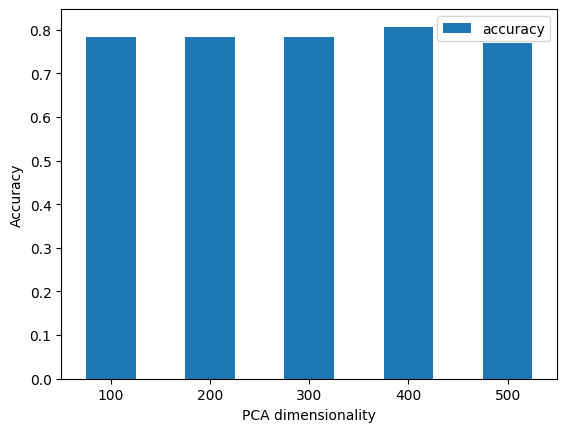

In [ ]:
df_acc = {"accuracy": [], "dim": []}

for dim in range(100, 600, 100):
    embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
    pca_model = PCA(n_components=dim)
    pca_model.fit(embeddings_matrix)

    pca_embeddings = pca_model.transform(embeddings_matrix)
    array_list = [np.array(row) for row in pca_embeddings.tolist()]
    df['pca_embedding'] = pd.Series(array_list, index=df.index)

    x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])
    svm_model = svm.SVC(kernel='linear')
    svm_model.fit(list(x_train), y_train)
    preds = svm_model.predict(list(x_test))
    df_acc['dim'].append(dim)
    df_acc['accuracy'].append(accuracy_score(y_test, preds))

print(df_acc)
df_acc = pd.DataFrame(df_acc)

df_acc.plot.bar(x='dim', y='accuracy', rot=0)
plt.xlabel('PCA dimensionality')
plt.ylabel('Accuracy')
plt.show()

Dimensionality of around 400 seems to give the best results. Inspect this area a bit closer.

{'accuracy': [0.777988614800759, 0.7718216318785579, 0.7732447817836812, 0.7860531309297912, 0.7860531309297912], 'dim': [320, 350, 380, 410, 440]}


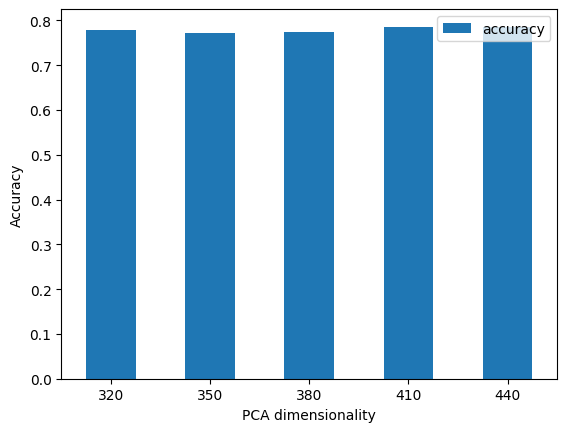

In [ ]:
df_acc = {"accuracy": [], "dim": []}

for dim in range(320, 460, 30):
    embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
    pca_model = PCA(n_components=dim)
    pca_model.fit(embeddings_matrix)

    pca_embeddings = pca_model.transform(embeddings_matrix)
    array_list = [np.array(row) for row in pca_embeddings.tolist()]
    df['pca_embedding'] = pd.Series(array_list, index=df.index)

    x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])
    svm_model = svm.SVC(kernel='linear')
    svm_model.fit(list(x_train), y_train)
    preds = svm_model.predict(list(x_test))
    df_acc['dim'].append(dim)
    df_acc['accuracy'].append(accuracy_score(y_test, preds))

print(df_acc)
df_acc = pd.DataFrame(df_acc)

df_acc.plot.bar(x='dim', y='accuracy', rot=0)
plt.xlabel('PCA dimensionality')
plt.ylabel('Accuracy')
plt.show()

Use PCA dimension 400. We later find that 370 works better.

## Find the best model

First prepare the data.

In [4]:
embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
pca_model = PCA(n_components=400)
pca_model.fit(embeddings_matrix)

pca_embeddings = pca_model.transform(embeddings_matrix)
array_list = [np.array(row) for row in pca_embeddings.tolist()]
df['pca_embedding'] = pd.Series(array_list, index=df.index)

x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])

### SVM

Support Vector Machines are known to work well with high-dimensional data.

In [ ]:
svm_model = svm.SVC(kernel='linear')
svm_model.fit(list(x_train), y_train)
preds = svm_model.predict(list(x_test))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

      female       0.79      0.82      0.81      1149
        male       0.78      0.73      0.75       959

    accuracy                           0.78      2108
   macro avg       0.78      0.78      0.78      2108
weighted avg       0.78      0.78      0.78      2108



Use grid search to find optimal hyperparameters.

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01],
}

In [ ]:
svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(list(x_train), y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
preds = best_model.predict(list(x_test))
print(classification_report(y_test, preds))

Fitting 2 folds for each of 24 candidates, totalling 48 fits
              precision    recall  f1-score   support

      female       0.80      0.82      0.81      1149
        male       0.78      0.76      0.77       959

    accuracy                           0.79      2108
   macro avg       0.79      0.79      0.79      2108
weighted avg       0.79      0.79      0.79      2108



In [ ]:
print(grid_search.best_params_)

{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
svm_model = svm.SVC(kernel='linear', C=10, gamma='scale')
svm_model.fit(list(x_train), y_train)
preds = svm_model.predict(list(x_test))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

      female       0.80      0.82      0.81      1149
        male       0.78      0.76      0.77       959

    accuracy                           0.79      2108
   macro avg       0.79      0.79      0.79      2108
weighted avg       0.79      0.79      0.79      2108



Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}. 

female       0.80      0.82      0.81      1149
male          0.78      0.76      0.77       959

accuracy                                           0.79      2108

### Random Forest

Random Forest is another classic algorithm that usually delivers good results.

In [ ]:
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=2, n_jobs=-1)

grid_search.fit(list(x_train), y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
preds = best_model.predict(list(x_test))
print(classification_report(y_test, preds))

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
              precision    recall  f1-score   support

      female       0.72      0.83      0.77      1149
        male       0.76      0.62      0.68       959

    accuracy                           0.74      2108
   macro avg       0.74      0.73      0.73      2108
weighted avg       0.74      0.74      0.73      2108



We're not impressed with results from Random Forest. 

### XGBoost

Try XGBoost. It usually performs well with high-dimensional data.

In [5]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'subsample': [0.5, 0.8],
    'colsample_bytree': [0.5, 0.8]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, n_jobs=-1)

y_train_log = y_train.apply(lambda x: 0 if x == "female" else 1)
grid_search.fit(list(x_train), y_train_log)
print(grid_search.best_params_)

best_params = grid_search.best_params_
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
xgb_model.fit(list(x_train), y_train_log)
preds = xgb_model.predict(list(x_test))
print(classification_report(y_test, preds))

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

In [ ]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, **best_params)
xgb_model.fit(list(x_train), y_train_log)
preds = xgb_model.predict(list(x_test))
print(classification_report(y_test, preds))

In [ ]:
print(classification_report(y_test.apply(lambda x: 0 if x == "female" else 1), preds))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1149
           1       0.76      0.72      0.74       959

    accuracy                           0.77      2108
   macro avg       0.77      0.77      0.77      2108
weighted avg       0.77      0.77      0.77      2108



Accuracy 0.77

## Fine-tune SVM

We've decided on using SVM as the model. Now we need to fine-tune it.

In [0]:
param_grid = {
    'kernel': ['linear', 'sigmoid', 'poly'],
    'C': [10, 100, 1000],
    'gamma': ['scale', 'auto'],
}

svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(list(x_train), y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
preds = best_model.predict(list(x_test))
print(classification_report(y_test, preds))

Fitting 2 folds for each of 18 candidates, totalling 36 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

      female       0.80      0.82      0.81      1149
        male       0.78      0.76      0.77       959

    accuracy                           0.79      2108
   macro avg       0.79      0.79      0.79      2108
weighted avg       0.79      0.79      0.79      2108



Still {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [5, 10, 20, 30, 50, 80],
    'gamma': ['scale'],
}

svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(list(x_train), y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
preds = best_model.predict(list(x_test))
print(classification_report(y_test, preds))

Fitting 2 folds for each of 12 candidates, totalling 24 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

      female       0.80      0.82      0.81      1149
        male       0.78      0.76      0.77       959

    accuracy                           0.79      2108
   macro avg       0.79      0.79      0.79      2108
weighted avg       0.79      0.79      0.79      2108



Still {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

In [ ]:
param_grid = {
    'kernel': ['linear'],
    'C': [6, 7, 8, 9, 10, 11, 12, 13],
    'gamma': ['scale'],
}

svm_model = SVC()
grid_search = GridSearchCV(svm_model, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(list(x_train), y_train)
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
preds = best_model.predict(list(x_test))
print(classification_report(y_test, preds))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
{'C': 13, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

      female       0.80      0.82      0.81      1149
        male       0.78      0.75      0.76       959

    accuracy                           0.79      2108
   macro avg       0.79      0.79      0.79      2108
weighted avg       0.79      0.79      0.79      2108



{'C': 13, 'gamma': 'scale', 'kernel': 'linear'}, but no accuracy improvement.

Try different PCA dimensions.

{'accuracy': [0.7675521821631879, 0.788899430740038, 0.7813092979127134, 0.8002846299810247, 0.7808349146110057, 0.7903225806451613, 0.7874762808349146, 0.7898481973434535, 0.7851043643263758, 0.7893738140417458, 0.7964895635673624, 0.7960151802656547, 0.8078747628083491, 0.7874762808349146, 0.8007590132827325, 0.7926944971537002, 0.780360531309298, 0.7945920303605313, 0.7922201138519924, 0.7936432637571158, 0.7874762808349146, 0.8031309297912713], 'dim': [50, 80, 110, 140, 170, 200, 230, 260, 290, 320, 350, 380, 410, 440, 470, 500, 530, 560, 590, 620, 650, 680]}


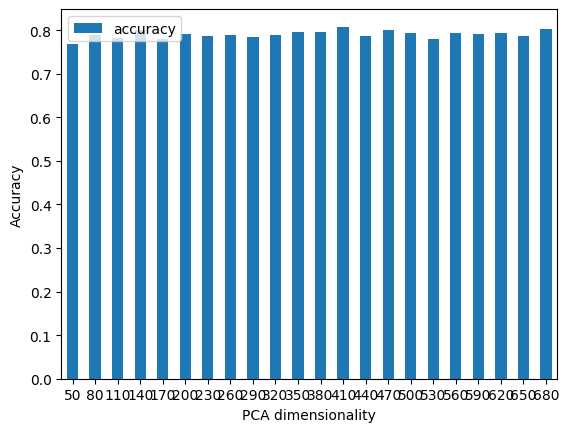

In [ ]:
df_acc = {"accuracy": [], "dim": []}

for dim in range(50, 700, 30):
    embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
    pca_model = PCA(n_components=dim)
    pca_model.fit(embeddings_matrix)

    pca_embeddings = pca_model.transform(embeddings_matrix)
    array_list = [np.array(row) for row in pca_embeddings.tolist()]
    df['pca_embedding'] = pd.Series(array_list, index=df.index)

    x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])
    svm_model = svm.SVC(kernel='linear', C=10, gamma='scale')
    svm_model.fit(list(x_train), y_train)
    preds = svm_model.predict(list(x_test))
    df_acc['dim'].append(dim)
    df_acc['accuracy'].append(accuracy_score(y_test, preds))

print(df_acc)
df_acc = pd.DataFrame(df_acc)

df_acc.plot.bar(x='dim', y='accuracy', rot=0)
plt.xlabel('PCA dimensionality')
plt.ylabel('Accuracy')
plt.show()

{'accuracy': [0.7988614800759013, 0.7936432637571158, 0.8012333965844403, 0.7827324478178368, 0.7808349146110057, 0.7950664136622391, 0.788899430740038, 0.7917457305502846, 0.7950664136622391], 'dim': [350, 360, 370, 380, 390, 400, 410, 420, 430]}


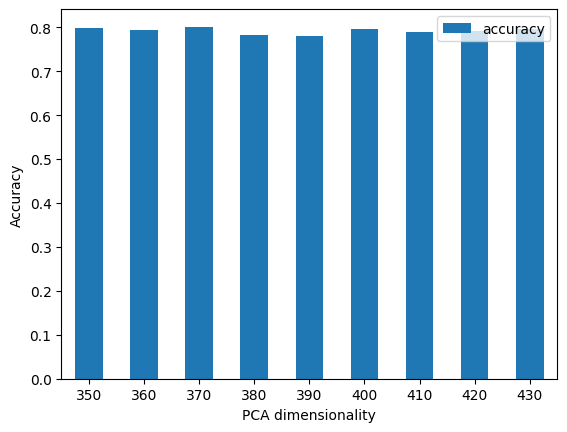

In [ ]:
df_acc = {"accuracy": [], "dim": []}

for dim in range(350, 440, 10):
    embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
    pca_model = PCA(n_components=dim)
    pca_model.fit(embeddings_matrix)

    pca_embeddings = pca_model.transform(embeddings_matrix)
    array_list = [np.array(row) for row in pca_embeddings.tolist()]
    df['pca_embedding'] = pd.Series(array_list, index=df.index)

    x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])
    svm_model = svm.SVC(kernel='linear', C=10, gamma='scale')
    svm_model.fit(list(x_train), y_train)
    preds = svm_model.predict(list(x_test))
    df_acc['dim'].append(dim)
    df_acc['accuracy'].append(accuracy_score(y_test, preds))

print(df_acc)
df_acc = pd.DataFrame(df_acc)

df_acc.plot.bar(x='dim', y='accuracy', rot=0)
plt.xlabel('PCA dimensionality')
plt.ylabel('Accuracy')
plt.show()

370 gives the accuracy of 80%. Use it.

In [ ]:
embeddings_matrix = np.vstack(df['oai_embedding'].to_numpy())
pca_model = PCA(n_components=370)
pca_model.fit(embeddings_matrix)

pca_embeddings = pca_model.transform(embeddings_matrix)
array_list = [np.array(row) for row in pca_embeddings.tolist()]
df['pca_embedding'] = pd.Series(array_list, index=df.index)

x_train, x_test, y_train, y_test = train_test_split(df['pca_embedding'], df['gender'], test_size=0.2, stratify=df['gender'])
svm_model = svm.SVC(kernel='linear', C=10, gamma='scale')
svm_model.fit(list(x_train), y_train)
preds = svm_model.predict(list(x_test))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

      female       0.81      0.82      0.82      1149
        male       0.78      0.78      0.78       959

    accuracy                           0.80      2108
   macro avg       0.80      0.80      0.80      2108
weighted avg       0.80      0.80      0.80      2108



We achieved the accuracy score of 80 using SVM and a good dimension number for PCA.

The classification report looks good, the results are not skewed in any particular direction.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=81f78dd5-4416-4826-9d0c-f76db50d69ad' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>